In [744]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Holt Winter Model

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [745]:
data= pd.read_csv("cleaned_data_csv.csv")

In [746]:
data.head()

,Continent,Location,Date,Total_Cases,New_Cases,New cases smoothed,Total_deaths,New_deaths,new deaths smoothed,total cases per million,...,median age,aged 65 older,aged 70 older,extreme poverty,cardiovasc death rate,diabetes prevalence,female smokers,male smokers,hospital beds per thousand,life expectancy
0,Asia,Afghanistan,2020-02-24,5,5,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
1,Asia,Afghanistan,2020-02-25,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
2,Asia,Afghanistan,2020-02-26,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
3,Asia,Afghanistan,2020-02-27,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
4,Asia,Afghanistan,2020-02-28,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83


In [747]:
def create_df(data,location):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Location']==location].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()
    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [748]:
data2=create_df(data,'Chile')

In [749]:
data3=create_df(data,'Ukraine')

In [750]:
data4=create_df(data,'Canada')

In [751]:
data2=data2.loc[:,['Date',"new cases per million"]]
data2=data2.set_index('Date')

In [752]:
data3=data3.loc[:,['Date',"new cases per million"]]
data3=data3.set_index('Date')

In [753]:
data4=data4.loc[:,['Date',"new cases per million"]]
data4=data4.set_index('Date')

In [754]:
data2

,new cases per million
Date,
2020-02-23,0.104
2020-02-24,0.000
2020-02-25,0.000
2020-02-26,0.000
2020-02-27,0.000
...,...
2022-03-01,0.000
2022-03-02,1930.580
2022-03-03,1285.214


In [755]:
# drop all occurrences of the value 0 in column 'A'

#df = pd.DataFrame(data2)
#data2 = df.drop(data2[data2["new cases per million"] == 0].index)

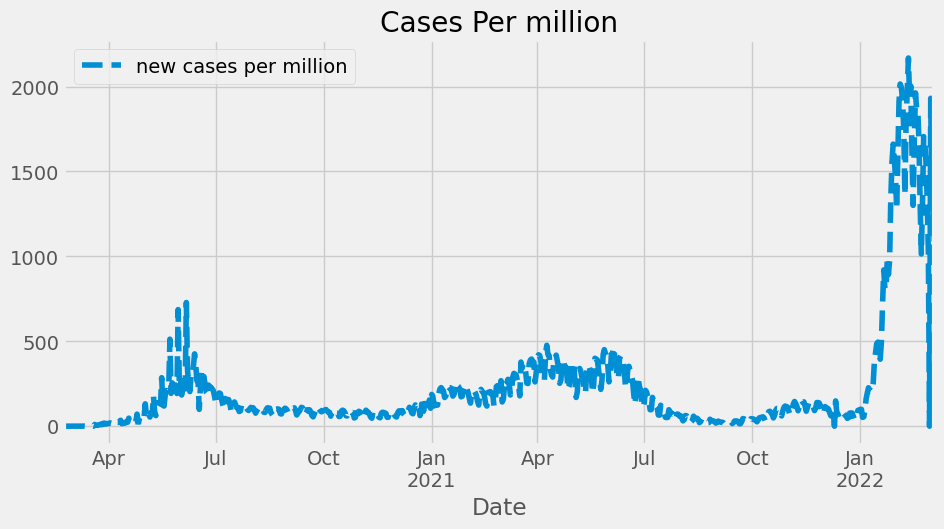

In [756]:
color_pal = sns.color_palette()
data2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

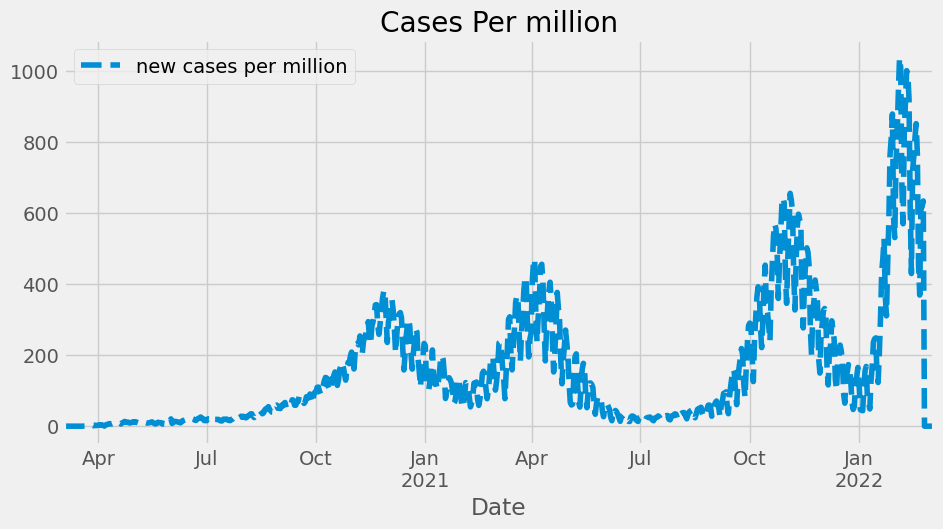

In [757]:
color_pal = sns.color_palette()
data3.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

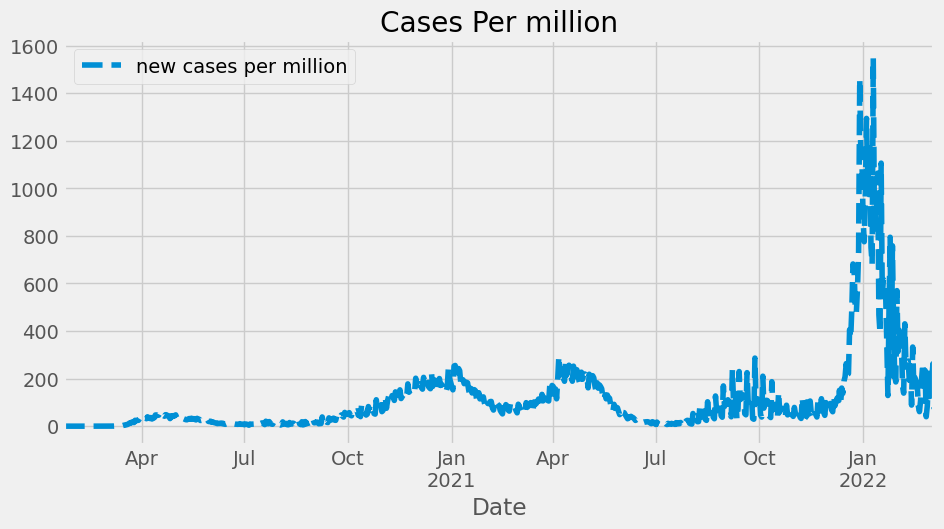

In [758]:
color_pal = sns.color_palette()
data4.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

In [759]:
from pandas.api.types import CategoricalDtype

cat_type= CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

def  create_features(df, label=None):
  df=df.copy()
  df['Date']=df.index
  df['hour']=df['Date'].dt.hour
  df['dayofweek']=df['Date'].dt.dayofweek
  df['weekday']=df['Date'].dt.day_name()
  df['weekday']=df['weekday'].astype(cat_type)
  df['quarter']=df['Date'].dt.quarter
  df['month']=df['Date'].dt.month
  df['year']=df['Date'].dt.year
  df['dayofyear']=df['Date'].dt.dayofyear
  df['dayofmonth']=df['Date'].dt.day
  df['weekofyear']=df['Date'].dt.weekofyear
  df['date_offset']=(df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

  df['season']=pd.cut(df['date_offset'], [0,300, 602, 900,1300],
                      labels=['Spring','Summer','Fall','Winter']
                      )
  X=df[['hour','dayofweek','quarter','month','year','dayofyear',
        'dayofmonth','weekofyear','weekday',
        'season']]
  if label:
    y=df[label]
    return X,y
  return X

X,y = create_features(data2,label="new cases per million")
features_and_target = pd.concat([X,y],axis=1)         


In [760]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,new cases per million
Date,,,,,,,,,,,
2020-02-23,0,6,1,2,2020,54,23,8,Sunday,Winter,0.104
2020-02-24,0,0,1,2,2020,55,24,9,Monday,Winter,0.000
2020-02-25,0,1,1,2,2020,56,25,9,Tuesday,Winter,0.000
2020-02-26,0,2,1,2,2020,57,26,9,Wednesday,Winter,0.000
2020-02-27,0,3,1,2,2020,58,27,9,Thursday,Winter,0.000


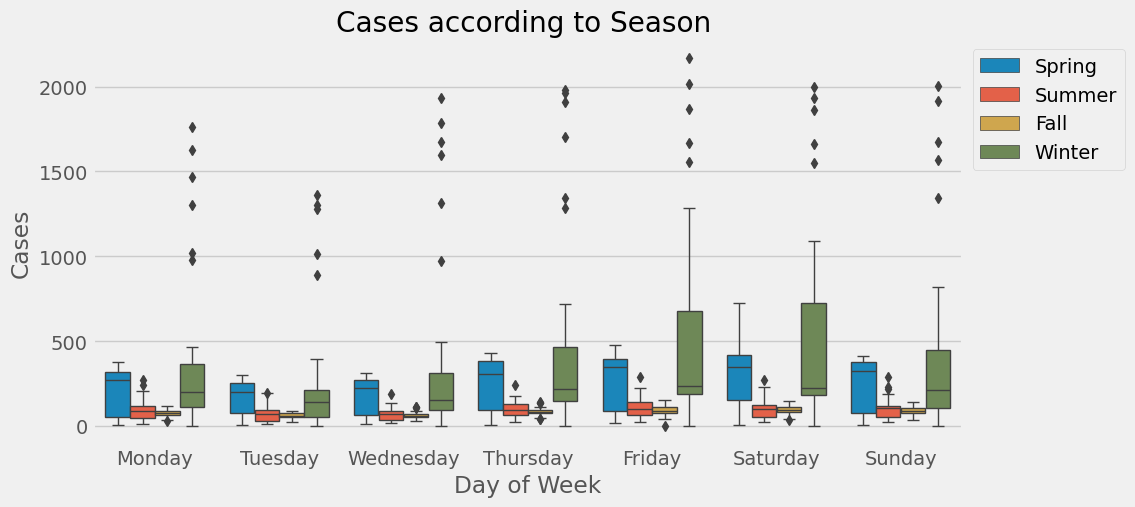

In [761]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y="new cases per million",
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Cases according to Season ')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Cases')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

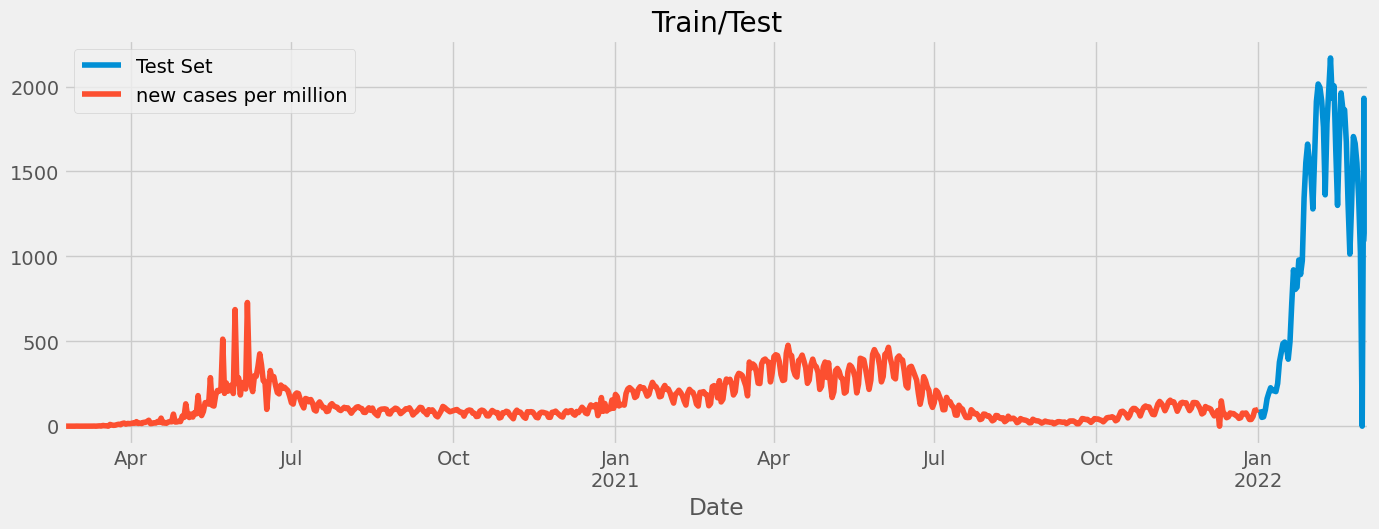

In [762]:
 split_date='01-jan-2022'

 date_train_asia = data2.loc[data2.index <=split_date].copy()
 date_test_asia = data2.loc[data2.index >split_date].copy()

 date_test_asia \
        .rename(columns={"new cases per million": 'Test Set'}) \
        .join(date_train_asia.rename(columns={'7 days MA new cases': 'Training Set'}),
              how='outer') \
        .plot(figsize=(15,5), title='Train/Test')
plt.show()

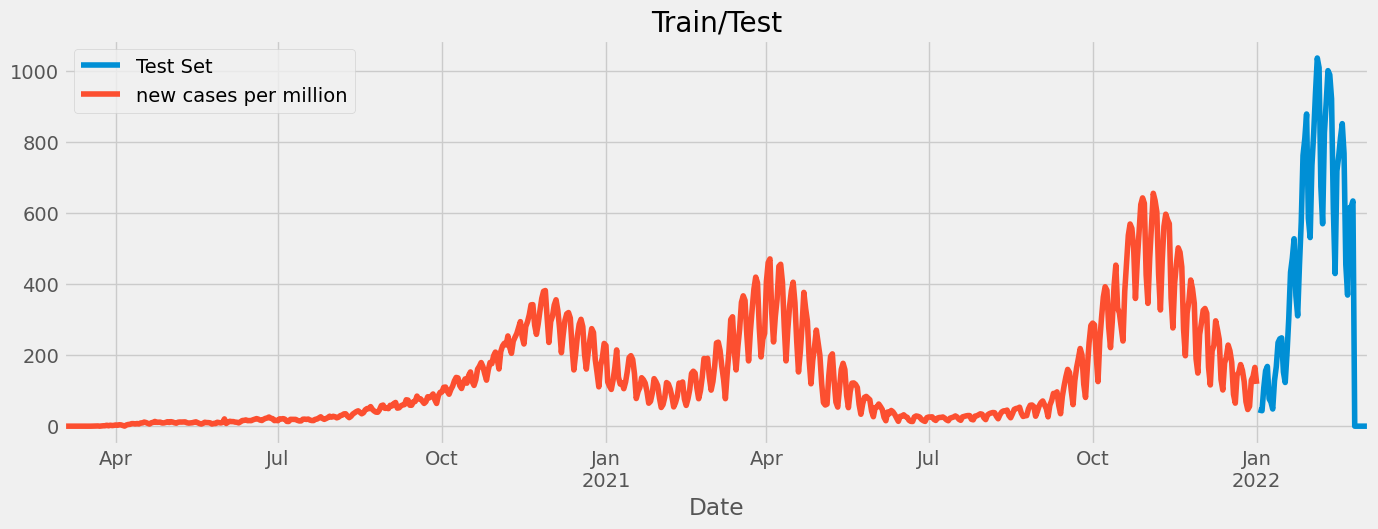

In [763]:
split_date='01-jan-2022'

date_train2 = data3.loc[data3.index <=split_date].copy()
date_test2 = data3.loc[data3.index >split_date].copy()

date_test2\
        .rename(columns={"new cases per million": 'Test Set'}) \
        .join(date_train2.rename(columns={'7 days MA new cases': 'Training Set'}),
              how='outer') \
        .plot(figsize=(15,5), title='Train/Test')
plt.show()

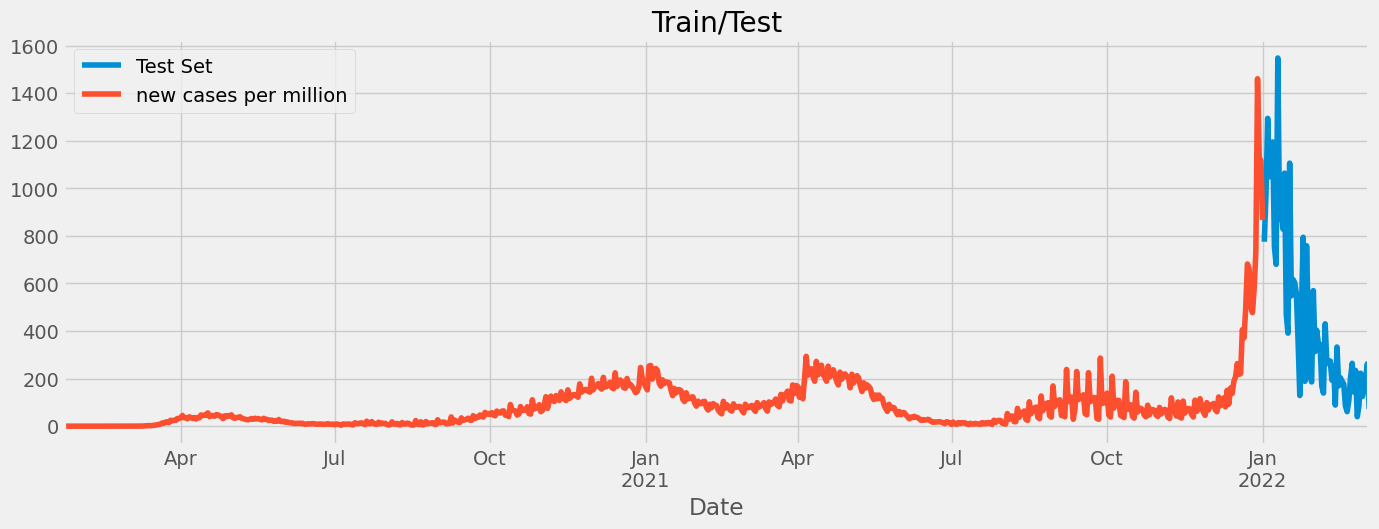

In [764]:
 split_date='01-jan-2022'

 date_train3 = data4.loc[data4.index <=split_date].copy()
 date_test3 = data4.loc[data4.index >split_date].copy()

 date_test3 \
        .rename(columns={"new cases per million": 'Test Set'}) \
        .join(date_train3.rename(columns={'7 days MA new cases': 'Training Set'}),
              how='outer') \
        .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [765]:
data2

,new cases per million
Date,
2020-02-23,0.104
2020-02-24,0.000
2020-02-25,0.000
2020-02-26,0.000
2020-02-27,0.000
...,...
2022-03-01,0.000
2022-03-02,1930.580
2022-03-03,1285.214


In [766]:
#Holt Winter Mode,

<bound method Axis.set_major_formatter of <matplotlib.axis.XAxis object at 0x7f7510093730>>

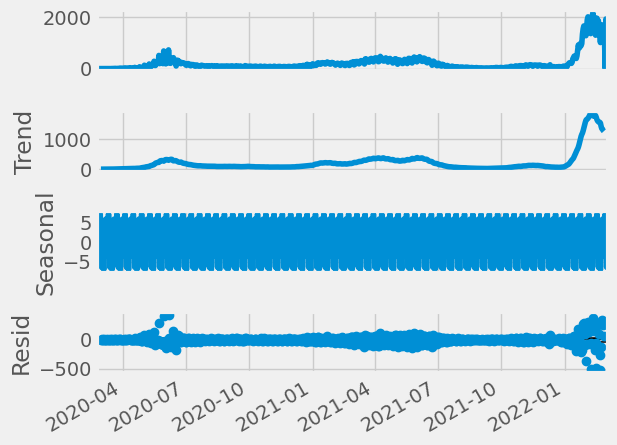

In [767]:
#seasonal_decompose(data2,model='additive').plot();


from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data2,period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
#date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter


<bound method Axis.set_major_formatter of <matplotlib.axis.XAxis object at 0x7f750be53700>>

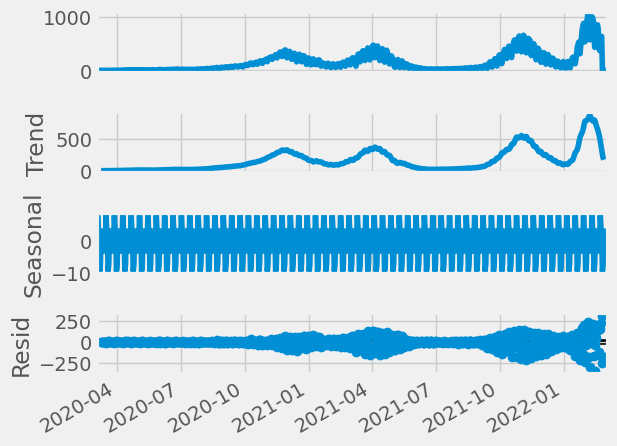

In [768]:
#seasonal_decompose(data2,model='additive').plot();


from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data3,period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
#date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter


<bound method Axis.set_major_formatter of <matplotlib.axis.XAxis object at 0x7f750bcf4910>>

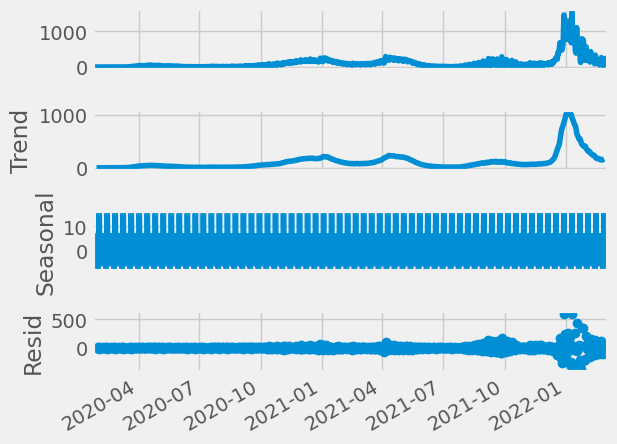

In [769]:
#seasonal_decompose(data2,model='additive').plot();


from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data4,period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
#date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter


In [770]:
hwmodel=ExponentialSmoothing(date_train_asia,trend='add', seasonal='add', seasonal_periods=4).fit()

In [771]:
train_pred=hwmodel.forecast(365)  

In [772]:
train_pred

2022-01-02     67.000389
2022-01-03     71.513176
2022-01-04     74.553350
2022-01-05     72.309870
2022-01-06     72.969992
                 ...    
2022-12-28    604.264613
2022-12-29    608.777400
2022-12-30    611.817574
2022-12-31    609.574094
2023-01-01    610.234216
Freq: D, Length: 365, dtype: float64

In [773]:
hwmodel=ExponentialSmoothing(date_train2,trend='add', seasonal='add', seasonal_periods=4).fit()

In [774]:
train_pred2=hwmodel.forecast(365)  

In [775]:
train_pred2

2022-01-02    119.243877
2022-01-03    119.136223
2022-01-04    119.158322
2022-01-05    119.247353
2022-01-06    119.295711
                 ...    
2022-12-28    123.908900
2022-12-29    123.801246
2022-12-30    123.823345
2022-12-31    123.912376
2023-01-01    123.960734
Freq: D, Length: 365, dtype: float64

In [776]:
hwmodel=ExponentialSmoothing(date_train3,trend='add', seasonal='add', seasonal_periods=4).fit()

In [777]:
train_pred3=hwmodel.forecast(365)  

In [778]:
train_pred3

2022-01-02     1181.784530
2022-01-03     1251.622831
2022-01-04     1324.422910
2022-01-05     1396.890033
2022-01-06     1471.400128
                  ...     
2022-12-28    27247.188395
2022-12-29    27317.026697
2022-12-30    27389.826775
2022-12-31    27462.293899
2023-01-01    27536.803994
Freq: D, Length: 365, dtype: float64

<Axes: xlabel='Date'>

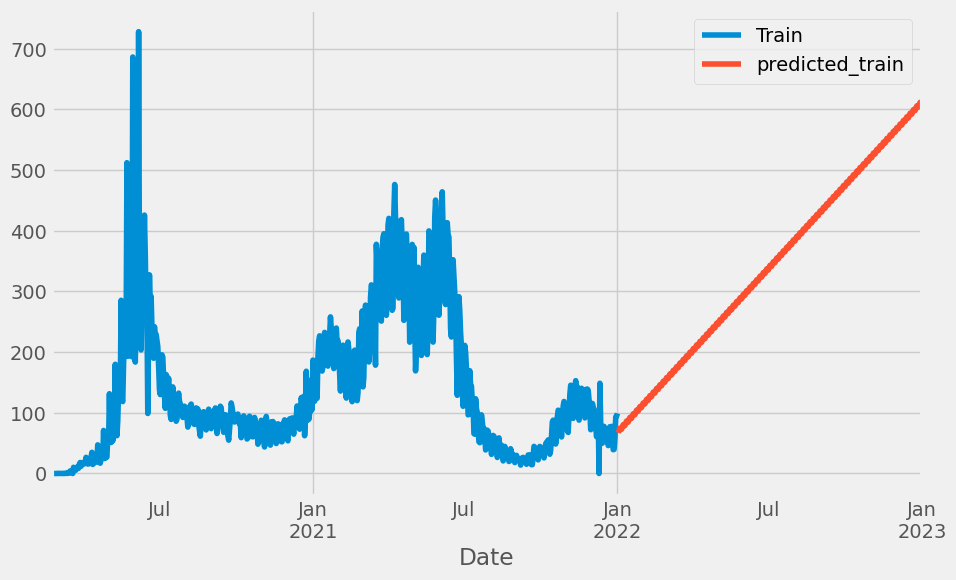

In [779]:
date_train_asia["new cases per million"].plot(legend=True, label='Train', figsize=(10,6))
#date_test_asia["new cases per million"].plot(legend=True, label='Test')

train_pred.plot(legend=True, label='predicted_train')

<Axes: xlabel='Date'>

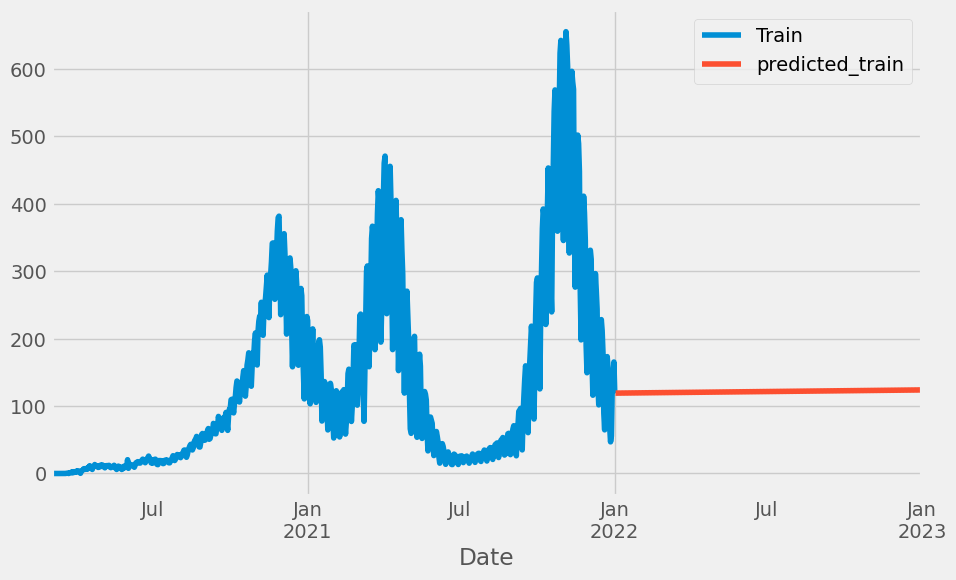

In [780]:
date_train2["new cases per million"].plot(legend=True, label='Train', figsize=(10,6))
#date_test_asia["new cases per million"].plot(legend=True, label='Test')

train_pred2.plot(legend=True, label='predicted_train')

<Axes: xlabel='Date'>

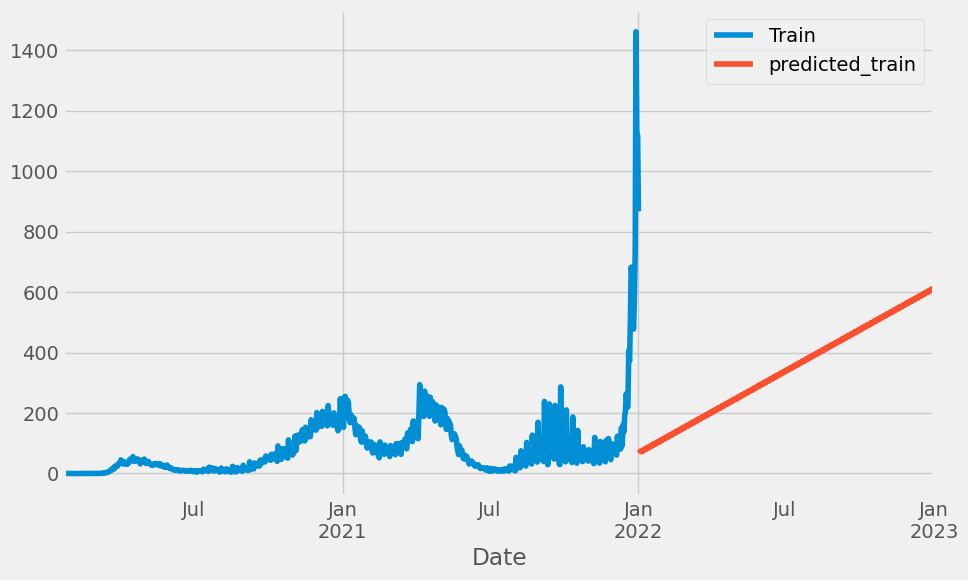

In [781]:
date_train3["new cases per million"].plot(legend=True, label='Train', figsize=(10,6))
#date_test_asia["new cases per million"].plot(legend=True, label='Test')

train_pred.plot(legend=True, label='predicted_train')

In [782]:
final_model=ExponentialSmoothing(data2,trend='add', seasonal='add', seasonal_periods=4).fit()

In [783]:
fitted_model = final_model.forecast(365)

In [784]:
pred=fitted_model

<Axes: xlabel='Date'>

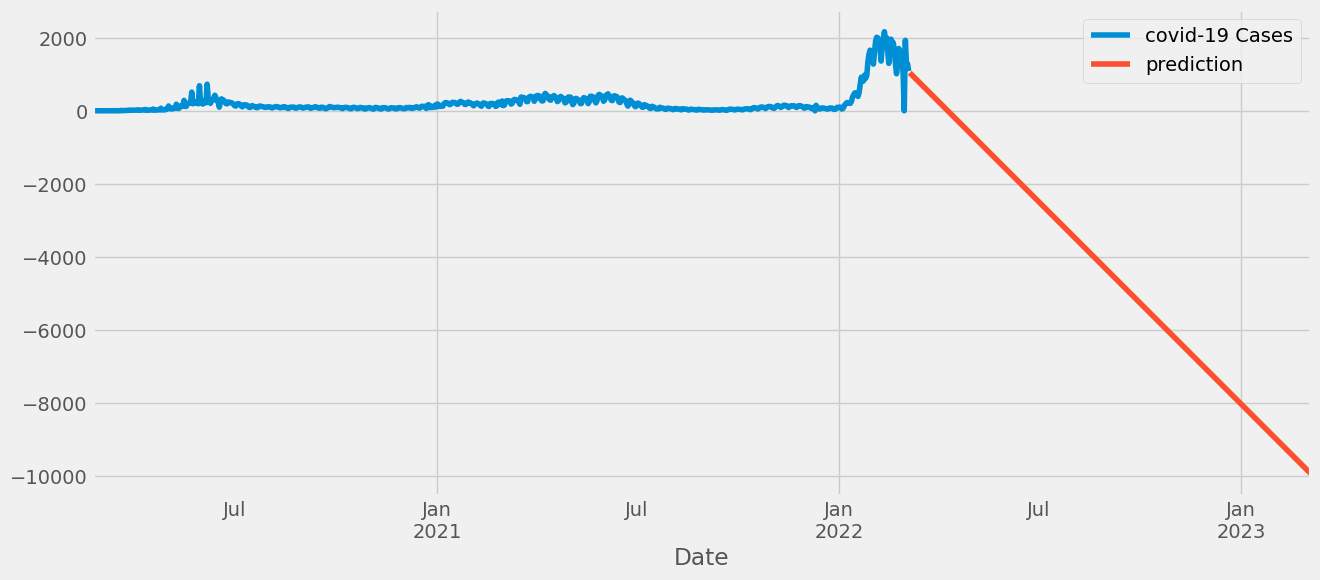

In [785]:
data2["new cases per million"].plot(legend=True, label='covid-19 Cases', figsize=(14,6))
pred.plot(legend=True, label='prediction')

In [786]:
final_model2=ExponentialSmoothing(data3,trend='add', seasonal='add', seasonal_periods=4).fit()

In [787]:
fitted_model2 = final_model2.forecast(365)

In [788]:
pred2=fitted_model2

<Axes: xlabel='Date'>

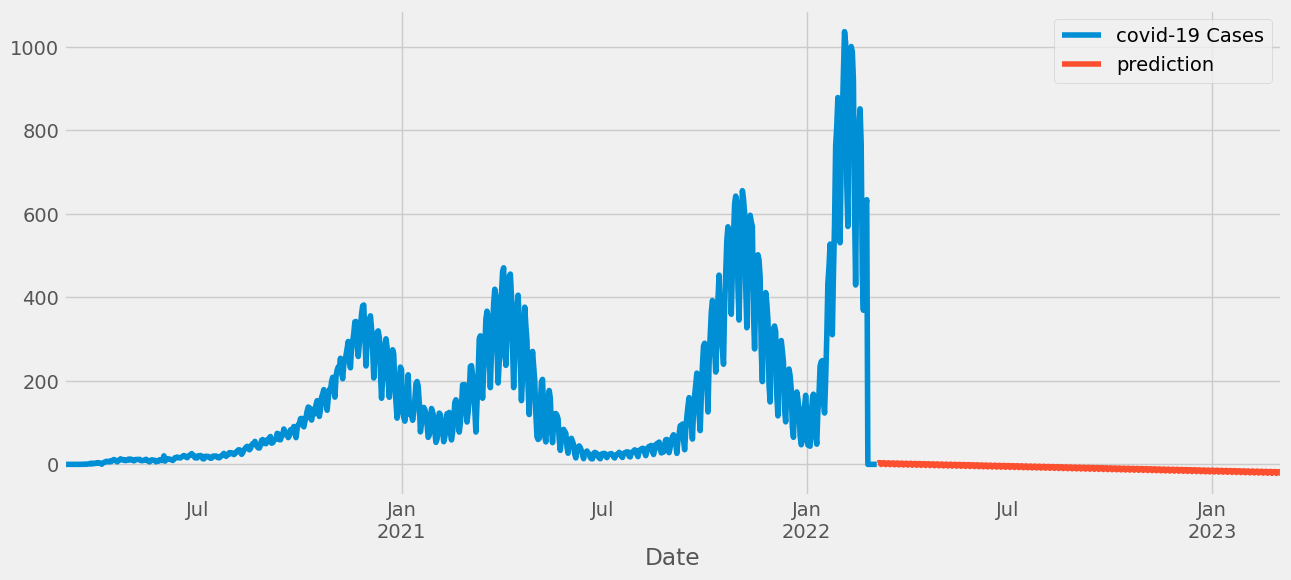

In [789]:
data3["new cases per million"].plot(legend=True, label='covid-19 Cases', figsize=(14,6))
pred2.plot(legend=True, label='prediction')

In [790]:
final_model3=ExponentialSmoothing(data4,trend='add', seasonal='add', seasonal_periods=4).fit()

In [791]:
fitted_model3 = final_model3.forecast(365)

In [792]:
pred3=fitted_model3

<Axes: xlabel='Date'>

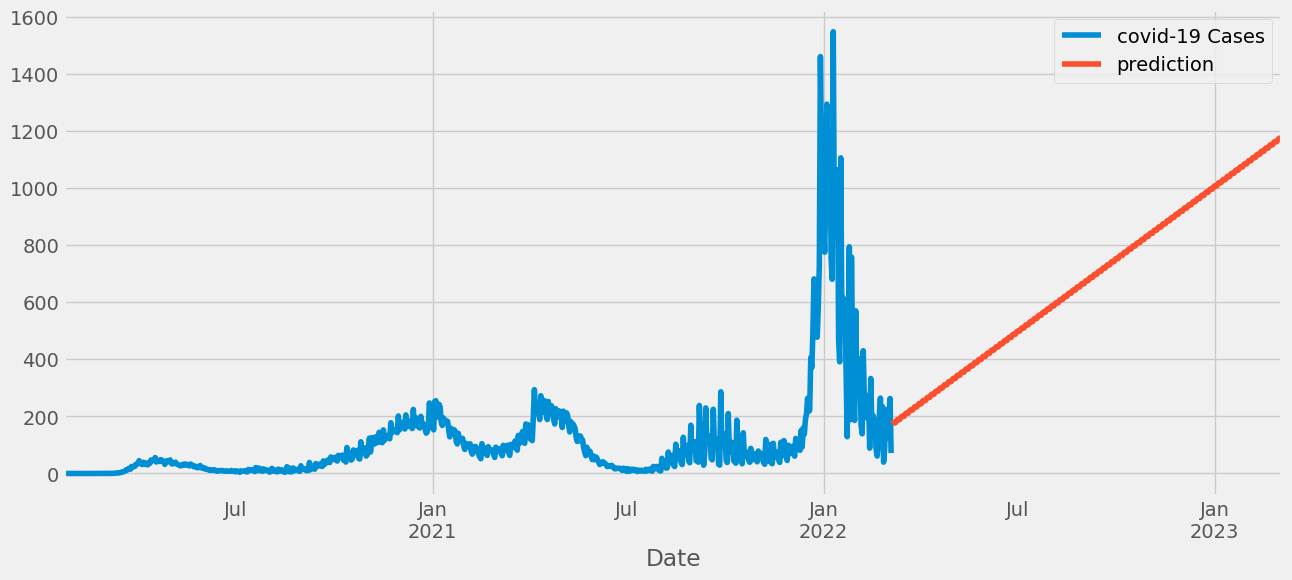

In [793]:
data4["new cases per million"].plot(legend=True, label='covid-19 Cases', figsize=(14,6))
pred3.plot(legend=True, label='prediction')

In [794]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
holt = Holt(np.asarray(date_train_asia["new cases per million"])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)   

In [795]:
#Obtaining the predictions of the holt linear model using test data

y_pred=date_test_asia.copy()

model_scores = []
y_pred["Holt"] = holt.forecast(len(date_test_asia))
model_scores.append(np.sqrt(mean_squared_error(y_pred["new cases per million"], y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred["new cases per million"], y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  893.995798708935


In [796]:
hw_model = ExponentialSmoothing((date_train_asia)).fit()

In [797]:
train_predicted = hw_model.fittedvalues
train_actual = date_train_asia

test_predicted = hw_model.predict(start=len(date_train_asia), end=len(date_train_asia)+len(date_test_asia)-1)
test_actual = date_test_asia


In [798]:
mean_train = np.mean(train_actual)

In [799]:
mean_train

new cases per million    138.625626
dtype: float64

In [800]:
# For training set:
sst_train = np.sum((train_actual - mean_train)**2)
sse_train = np.sum((train_actual - train_predicted)**2)

# For testing set:
sst_test = np.sum((test_actual - mean_train)**2)
sse_test = np.sum((test_actual - test_predicted)**2)

In [801]:
r_squared_train = 1 - (sse_train / sst_train)
r_squared_test = 1 - (sse_test / sst_test)

In [802]:
r_squared_train

2020-02-23 00:00:00      NaN
2020-02-24 00:00:00      NaN
2020-02-25 00:00:00      NaN
2020-02-26 00:00:00      NaN
2020-02-27 00:00:00      NaN
                        ... 
2021-12-29 00:00:00      NaN
2021-12-30 00:00:00      NaN
2021-12-31 00:00:00      NaN
2022-01-01 00:00:00      NaN
new cases per million    1.0
Length: 680, dtype: float64

In [803]:
r_squared_test

2022-01-02 00:00:00      NaN
2022-01-03 00:00:00      NaN
2022-01-04 00:00:00      NaN
2022-01-05 00:00:00      NaN
2022-01-06 00:00:00      NaN
                        ... 
2022-03-02 00:00:00      NaN
2022-03-03 00:00:00      NaN
2022-03-04 00:00:00      NaN
2022-03-05 00:00:00      NaN
new cases per million    1.0
Length: 64, dtype: float64

In [804]:
from sklearn.metrics import mean_squared_error
import math

rmse_train = math.sqrt(mean_squared_error(train_actual, train_predicted))
rmse_test = math.sqrt(mean_squared_error(test_actual, test_predicted))

In [805]:
rmse_train

48.902945933833315

In [806]:
rmse_test

1236.5636516330733

In [807]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
holt2 = Holt(np.asarray(date_train2["new cases per million"])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)   

In [808]:
#Obtaining the predictions of the holt linear model using test data

y_pred2=date_test2.copy()

model_scores = []
y_pred2["Holt"] = holt.forecast(len(date_test2))
model_scores.append(np.sqrt(mean_squared_error(y_pred2["new cases per million"], y_pred2["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred2["new cases per million"], y_pred2["Holt"])))

Root Mean Square Error Holt's Linear Model:  351.50421080113193


In [809]:
hw_model2 = ExponentialSmoothing((date_train2)).fit()

In [810]:
train_predicted2 = hw_model2.fittedvalues
train_actual2 = date_train2

test_predicted2 = hw_model2.predict(start=len(date_train2), end=len(date_train2)+len(date_test2)-1)
test_actual2 = date_test2


In [811]:
mean_train2 = np.mean(train_actual2)

In [812]:
mean_train2

new cases per million    132.28127
dtype: float64

In [813]:
# For training set:
sst_train2 = np.sum((train_actual2 - mean_train2)**2)
sse_train2 = np.sum((train_actual2 - train_predicted2)**2)

In [814]:
# For testing set:
sst_test2 = np.sum((test_actual2 - mean_train2)**2)
sse_test2 = np.sum((test_actual2 - test_predicted2)**2)

In [815]:
r_squared_train2 = 1 - (sse_train2 / sst_train2)
r_squared_test2 = 1 - (sse_test2 / sst_test2)

In [816]:
r_squared_train2

2020-03-03 00:00:00      NaN
2020-03-04 00:00:00      NaN
2020-03-05 00:00:00      NaN
2020-03-06 00:00:00      NaN
2020-03-07 00:00:00      NaN
                        ... 
2021-12-29 00:00:00      NaN
2021-12-30 00:00:00      NaN
2021-12-31 00:00:00      NaN
2022-01-01 00:00:00      NaN
new cases per million    1.0
Length: 671, dtype: float64

In [817]:
r_squared_test2

2022-01-02 00:00:00      NaN
2022-01-03 00:00:00      NaN
2022-01-04 00:00:00      NaN
2022-01-05 00:00:00      NaN
2022-01-06 00:00:00      NaN
                        ... 
2022-03-02 00:00:00      NaN
2022-03-03 00:00:00      NaN
2022-03-04 00:00:00      NaN
2022-03-05 00:00:00      NaN
new cases per million    1.0
Length: 64, dtype: float64

In [818]:
from sklearn.metrics import mean_squared_error
import math

rmse_train2 = math.sqrt(mean_squared_error(train_actual2, train_predicted2))
rmse_test2 = math.sqrt(mean_squared_error(test_actual2, test_predicted2))

In [819]:
rmse_train2

41.32896334413552

In [820]:
rmse_test2

460.61256916306223

In [821]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
holt3 = Holt(np.asarray(date_train3["new cases per million"])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)   

In [822]:
#Obtaining the predictions of the holt linear model using test data

y_pred3=date_test3.copy()

model_scores = []
y_pred3["Holt"] = holt.forecast(len(date_test3))
model_scores.append(np.sqrt(mean_squared_error(y_pred3["new cases per million"], y_pred3["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred3["new cases per million"], y_pred3["Holt"])))


Root Mean Square Error Holt's Linear Model:  519.6707974415162


In [823]:
hw_model3 = ExponentialSmoothing((date_train3)).fit()

In [824]:
train_predicted3 = hw_model3.fittedvalues
train_actual3 = date_train3

test_predicted3 = hw_model3.predict(start=len(date_train3), end=len(date_train3)+len(date_test3)-1)
test_actual3 = date_test3


In [825]:
mean_train3 = np.mean(train_actual3)

In [826]:
mean_train3

new cases per million    83.47961
dtype: float64

In [827]:
# For training set:
sst_train3 = np.sum((train_actual3 - mean_train3)**2)
sse_train3 = np.sum((train_actual3 - train_predicted3)**2)

# For testing set:
sst_test3 = np.sum((test_actual3 - mean_train3)**2)
sse_test3 = np.sum((test_actual3 - test_predicted3)**2)


In [828]:
r_squared_train3 = 1 - (sse_train3 / sst_train3)
r_squared_test3 = 1 - (sse_test3 / sst_test3)

In [829]:
r_squared_train3

2020-01-23 00:00:00      NaN
2020-01-24 00:00:00      NaN
2020-01-25 00:00:00      NaN
2020-01-26 00:00:00      NaN
2020-01-27 00:00:00      NaN
                        ... 
2021-12-29 00:00:00      NaN
2021-12-30 00:00:00      NaN
2021-12-31 00:00:00      NaN
2022-01-01 00:00:00      NaN
new cases per million    1.0
Length: 711, dtype: float64

In [830]:
r_squared_test3

2022-01-02 00:00:00      NaN
2022-01-03 00:00:00      NaN
2022-01-04 00:00:00      NaN
2022-01-05 00:00:00      NaN
2022-01-06 00:00:00      NaN
                        ... 
2022-03-02 00:00:00      NaN
2022-03-03 00:00:00      NaN
2022-03-04 00:00:00      NaN
2022-03-05 00:00:00      NaN
new cases per million    1.0
Length: 64, dtype: float64

In [831]:
from sklearn.metrics import mean_squared_error
import math

rmse_train3 = math.sqrt(mean_squared_error(train_actual3, train_predicted3))
rmse_test3 = math.sqrt(mean_squared_error(test_actual3, test_predicted3))

In [832]:
rmse_train3

44.81589746224736

In [833]:
rmse_test3

630.8646948583613

In [834]:
rmse_values = (rmse_test,rmse_test2,rmse_test3)

Text(0, 0.5, 'RMSE')

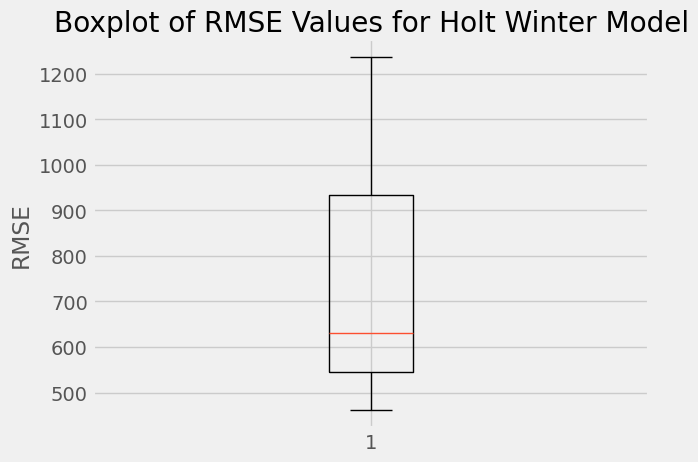

In [835]:
# Create a box plot of the RMSE values
#sns.boxplot(x=rmse_values)
#plt.xlabel('RMSE')
#plt.title('Box Plot of RMSE Values for Holt Winter Model')
#plt.show()

# Create a boxplot
fig, ax = plt.subplots()
ax.boxplot(rmse_values)
ax.set_title('Boxplot of RMSE Values for Holt Winter Model')
ax.set_ylabel('RMSE')

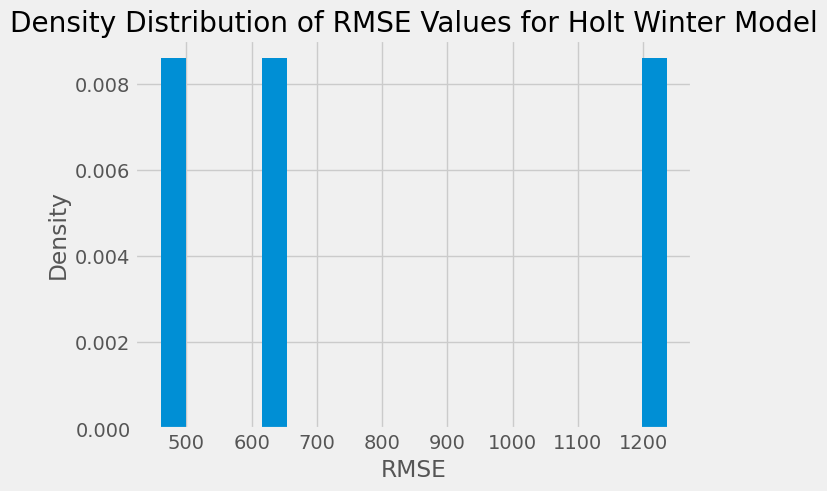

In [836]:
# Create a density distribution
fig, ax = plt.subplots()
ax.hist(rmse_values, density=True, bins=20)
ax.set_title('Density Distribution of RMSE Values for Holt Winter Model')
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
plt.show()

In [837]:
#FB Prophet

In [838]:
# Rename columns as required by Prophet
data = date_train_asia.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [839]:
# Rename columns as required by Prophet
test_data = date_test_asia.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [840]:
data

,ds,y
0,2020-02-23,0.104
1,2020-02-24,0.000
2,2020-02-25,0.000
3,2020-02-26,0.000
4,2020-02-27,0.000
...,...,...
674,2021-12-28,39.662
675,2021-12-29,57.047
676,2021-12-30,93.221
677,2021-12-31,94.314


In [841]:
# Define function to evaluate model performance
def evaluate_model(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mse, rmse, mape

In [842]:
# Initialize and fit the Prophet model on train data
model = Prophet()
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/vopx2k6e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/0g7dy15w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2737', 'data', 'file=/tmp/tmpwcikqldh/vopx2k6e.json', 'init=/tmp/tmpwcikqldh/0g7dy15w.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_model69ha0w71/prophet_model-20230405071452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [843]:
n_days = 360

In [844]:
future_dates = model.make_future_dataframe(periods=n_days)

In [845]:
# Use the trained model to make predictions for the next n_days
forecast = model.predict(future_dates)
# Access the 'yhat_lower' column
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-23,-17.278658,-90.756809,56.472406
1,2020-02-24,-31.110061,-103.586411,47.880973
2,2020-02-25,-57.832074,-132.172840,17.264907
3,2020-02-26,-52.162332,-123.830141,27.633261
4,2020-02-27,-8.421586,-82.183514,62.844831
...,...,...,...,...
1034,2022-12-23,116.978621,-541.400028,751.631919
1035,2022-12-24,132.985526,-511.171391,778.733565
1036,2022-12-25,108.076933,-558.598730,761.526519
1037,2022-12-26,92.294662,-569.370160,729.026532


In [846]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model, forecast)
fig.show()

In [847]:
# Extract the forecasted values
forecast = forecast[['ds', 'yhat']]
forecast = forecast[-n_days:]

In [848]:
# Evaluate model performance on test data
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['ds', 'yhat']]
test_predictions = test_predictions.merge(test_data, on='ds')
test_predictions = test_predictions[['yhat', 'y']]
mse, rmse, mape = evaluate_model(test_predictions['yhat'], test_predictions['y'])

In [849]:

# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 1523518.22
Root Mean Squared Error (RMSE): 1234.31
Mean Absolute Percentage Error (MAPE): inf%


In [850]:
# Rename columns as required by Prophet
data2_1 = date_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [851]:
# Rename columns as required by Prophet
test_data2 = date_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [852]:
# Define function to evaluate model performance
def evaluate_model2(predictions2, actual2):
    mse2 = mean_squared_error(actual2, predictions2)
    rmse2 = np.sqrt(mse2)
    mape2 = np.mean(np.abs((actual2 - predictions2) / actual2)) * 100
    return mse2, rmse2, mape2


In [853]:
# Initialize and fit the Prophet model on train data
model2 = Prophet()
model2.fit(data2_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/d4xbdfz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/abx82ad4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98659', 'data', 'file=/tmp/tmpwcikqldh/d4xbdfz1.json', 'init=/tmp/tmpwcikqldh/abx82ad4.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_modelrghfup7_/prophet_model-20230405071452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [854]:
n_days2 = 360

In [855]:
future_dates2 = model2.make_future_dataframe(periods=n_days2)

In [856]:
# Use the trained model to make predictions for the next n_days
forecast2 = model2.predict(future_dates2)
# Access the 'yhat_lower' column
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-03,-61.781326,-191.250125,77.206983
1,2020-03-04,-38.997619,-160.983615,90.615362
2,2020-03-05,-14.615623,-142.794747,121.318095
3,2020-03-06,-11.934006,-135.031886,124.499198
4,2020-03-07,-20.623834,-141.495295,118.577418
...,...,...,...,...
1025,2022-12-23,808.180404,587.825200,1000.701444
1026,2022-12-24,799.966147,596.885676,999.005003
1027,2022-12-25,760.447433,552.385331,947.439152
1028,2022-12-26,734.366627,517.060668,933.510342


In [857]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model2, forecast2)
fig.show()

In [858]:
# Evaluate model performance on test data
test_predictions2 = model2.predict(test_data2[['ds']])
test_predictions2 = test_predictions2[['ds', 'yhat']]
test_predictions2 = test_predictions2.merge(test_data2, on='ds')
test_predictions2 = test_predictions2[['yhat', 'y']]
mse2, rmse2, mape2 = evaluate_model(test_predictions2['yhat'], test_predictions2['y'])

In [859]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape2:.2f}%')

Mean Squared Error (MSE): 111922.84
Root Mean Squared Error (RMSE): 334.55
Mean Absolute Percentage Error (MAPE): inf%


In [860]:
# Rename columns as required by Prophet
data3_1 = date_train3.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [861]:
# Rename columns as required by Prophet
test_data3 = date_test3.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [862]:
# Define function to evaluate model performance
def evaluate_model3(predictions3, actual3):
    mse3 = mean_squared_error(actual3, predictions3)
    rmse3 = np.sqrt(mse3)
    mape3 = np.mean(np.abs((actual3 - predictions3) / actual3)) * 100
    return mse3, rmse3, mape3

In [863]:
# Initialize and fit the Prophet model on train data
model3 = Prophet()
model3.fit(data3_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/sv9avh94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/igai_f8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80958', 'data', 'file=/tmp/tmpwcikqldh/sv9avh94.json', 'init=/tmp/tmpwcikqldh/igai_f8w.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_modeleol8o7le/prophet_model-20230405071453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [864]:
n_days3 = 360

In [865]:
future_dates3 = model3.make_future_dataframe(periods=n_days3)

In [866]:
# Use the trained model to make predictions for the next n_days
forecast3 = model3.predict(future_dates3)
# Access the 'yhat_lower' column
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-23,10.113749,-107.068702,124.705401
1,2020-01-24,9.944979,-112.340002,129.516274
2,2020-01-25,-11.547915,-134.546527,109.634004
3,2020-01-26,-22.055305,-142.519877,98.133306
4,2020-01-27,12.680316,-96.481680,129.084556
...,...,...,...,...
1065,2022-12-23,918.817923,660.327229,1193.874703
1066,2022-12-24,898.943529,625.846092,1167.070082
1067,2022-12-25,890.054639,623.041400,1178.094991
1068,2022-12-26,926.408759,654.174422,1204.983095


In [867]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model3, forecast3)
fig.show()

In [868]:
# Evaluate model performance on test data
test_predictions3 = model3.predict(test_data3[['ds']])
test_predictions3 = test_predictions3[['ds', 'yhat']]
test_predictions3 = test_predictions3.merge(test_data3, on='ds')
test_predictions3 = test_predictions3[['yhat', 'y']]
mse3, rmse3, mape3 = evaluate_model(test_predictions3['yhat'], test_predictions3['y'])

In [869]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse3:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse3:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape3:.2f}%')

Mean Squared Error (MSE): 157046.94
Root Mean Squared Error (RMSE): 396.29
Mean Absolute Percentage Error (MAPE): 102.36%


In [870]:
rmse_values3 = (rmse,rmse2,rmse3)

Text(0, 0.5, 'RMSE')

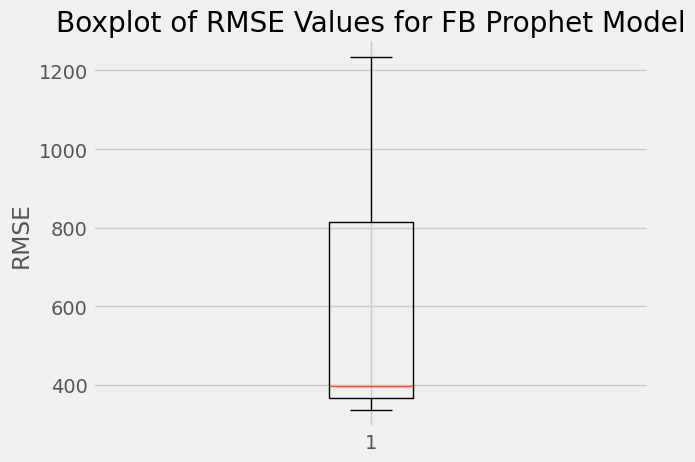

In [871]:
# Create a boxplot
fig, ax = plt.subplots()
ax.boxplot(rmse_values3)
ax.set_title('Boxplot of RMSE Values for FB Prophet Model')
ax.set_ylabel('RMSE')

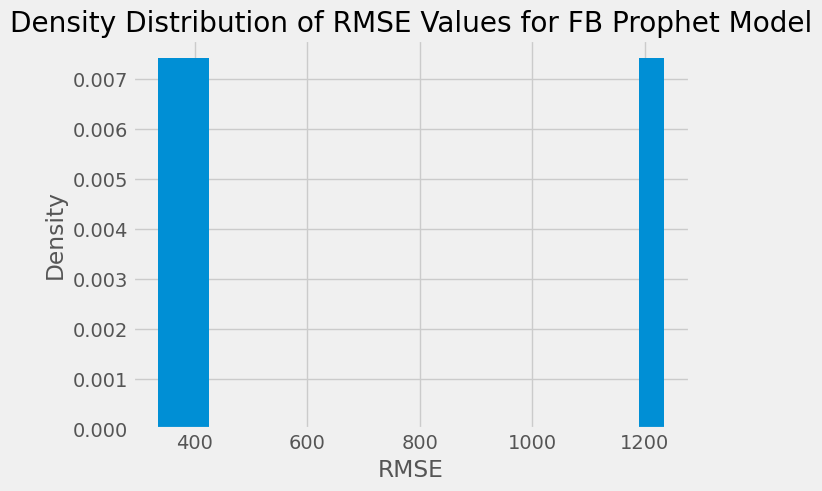

In [872]:
# Create a density distribution
fig, ax = plt.subplots()
ax.hist(rmse_values3, density=True, bins=20)
ax.set_title('Density Distribution of RMSE Values for FB Prophet Model')
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
plt.show()

In [873]:
data2_asia_prophet=data2.groupby('Date').sum('New_Cases').reset_index() \
  .rename(columns={'Date':'ds',
                   "new cases per million":'y'})

In [874]:
data2_asia_prophet

,ds,y
0,2020-02-23,0.104
1,2020-02-24,0.000
2,2020-02-25,0.000
3,2020-02-26,0.000
4,2020-02-27,0.000
...,...,...
737,2022-03-01,0.000
738,2022-03-02,1930.580
739,2022-03-03,1285.214
740,2022-03-04,1282.091


In [875]:
%%time
model = Prophet()
model.fit(data2_asia_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/ybkge70x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/2ll0ji38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40600', 'data', 'file=/tmp/tmpwcikqldh/ybkge70x.json', 'init=/tmp/tmpwcikqldh/2ll0ji38.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_modelagso8g9n/prophet_model-20230405071454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 88.5 ms, sys: 22.7 ms, total: 111 ms
Wall time: 196 ms


In [876]:
from prophet.diagnostics import performance_metrics, cross_validation
df_cv = cross_validation(model, initial='365 days', period='360 days', horizon = '100 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2021-11-25 00:00:00 and 2021-11-25 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/l2y6c8g4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/c0knu7aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89457', 'data', 'file=/tmp/tmpwcikqldh/l2y6c8g4.json', 'init=/tmp/tmpwcikqldh/c0knu7aw.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_model6tzo43lf/prophet_model-20230405071454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [877]:
df_p = performance_metrics(df_cv)

INFO:prophet:Skipping MAPE because y close to 0


In [878]:
print(df_p.columns)
print(df_p['rmse'].head())

Index(['horizon', 'mse', 'rmse', 'mae', 'mdape', 'smape', 'coverage'], dtype='object')
0    17.956242
1    20.173838
2    21.258527
3    21.716007
4    24.861040
Name: rmse, dtype: float64


In [879]:
#Create the model using Prophet 0.95 confidence
ML_Model = Prophet(interval_width=0.95)
#Fit the Model
ML_Model.fit(data2_asia_prophet)
#Create prediction Data
Cases_Prediction = ML_Model.make_future_dataframe(periods=360)
Cases_Prediction.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/t3c8_kxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcikqldh/5bw7u2yy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27376', 'data', 'file=/tmp/tmpwcikqldh/t3c8_kxr.json', 'init=/tmp/tmpwcikqldh/5bw7u2yy.json', 'output', 'file=/tmp/tmpwcikqldh/prophet_model66mgqiq1/prophet_model-20230405071455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
1097,2023-02-24
1098,2023-02-25
1099,2023-02-26
1100,2023-02-27
1101,2023-02-28


In [880]:
#predicting the future with date, and upper and lower limit of y value
Cases_Forecast = ML_Model.predict(Cases_Prediction)
Cases_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1097,2023-02-24,3995.148710,2940.198309,5075.353336
1098,2023-02-25,3994.030428,2868.357839,5014.615245
1099,2023-02-26,3959.098193,2872.988989,5000.506442
1100,2023-02-27,3925.426495,2801.944416,4993.302550
1101,2023-02-28,3870.872944,2823.859546,4994.375624


In [881]:
#Cases_forecasting = ML_Model.plot(Cases_Forecast, figsize=(15,5))

In [882]:
future=model.make_future_dataframe(periods=365)
forecast=model.predict(future)

In [883]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-23,-191.466977,-184.151526,198.112787,-191.466977,-191.466977,188.204871,188.204871,188.204871,13.547008,13.547008,13.547008,174.657863,174.657863,174.657863,0.0,0.0,0.0,-3.262106
1,2020-02-24,-189.604122,-222.683456,140.878242,-189.604122,-189.604122,142.290892,142.290892,142.290892,-14.100927,-14.100927,-14.100927,156.391820,156.391820,156.391820,0.0,0.0,0.0,-47.313230
2,2020-02-25,-187.741267,-298.781598,73.261488,-187.741267,-187.741267,74.909364,74.909364,74.909364,-64.509798,-64.509798,-64.509798,139.419162,139.419162,139.419162,0.0,0.0,0.0,-112.831903
3,2020-02-26,-185.878412,-279.351941,92.990478,-185.878412,-185.878412,95.331854,95.331854,95.331854,-28.633691,-28.633691,-28.633691,123.965545,123.965545,123.965545,0.0,0.0,0.0,-90.546558
4,2020-02-27,-184.015557,-230.467497,143.604605,-184.015557,-184.015557,130.714303,130.714303,130.714303,20.497177,20.497177,20.497177,110.217126,110.217126,110.217126,0.0,0.0,0.0,-53.301254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,2023-03-01,3847.011339,3224.973270,4589.190261,3201.502295,4499.542630,57.562792,57.562792,57.562792,-28.633691,-28.633691,-28.633691,86.196482,86.196482,86.196482,0.0,0.0,0.0,3904.574131
1103,2023-03-02,3854.285460,3306.483960,4667.052249,3208.065603,4509.883533,99.261878,99.261878,99.261878,20.497177,20.497177,20.497177,78.764701,78.764701,78.764701,0.0,0.0,0.0,3953.547338
1104,2023-03-03,3861.559581,3303.004018,4645.637089,3215.623971,4521.335902,105.845426,105.845426,105.845426,32.490039,32.490039,32.490039,73.355387,73.355387,73.355387,0.0,0.0,0.0,3967.405007
1105,2023-03-04,3868.833702,3289.737562,4658.968706,3221.748871,4532.453631,110.643423,110.643423,110.643423,40.710192,40.710192,40.710192,69.933230,69.933230,69.933230,0.0,0.0,0.0,3979.477125


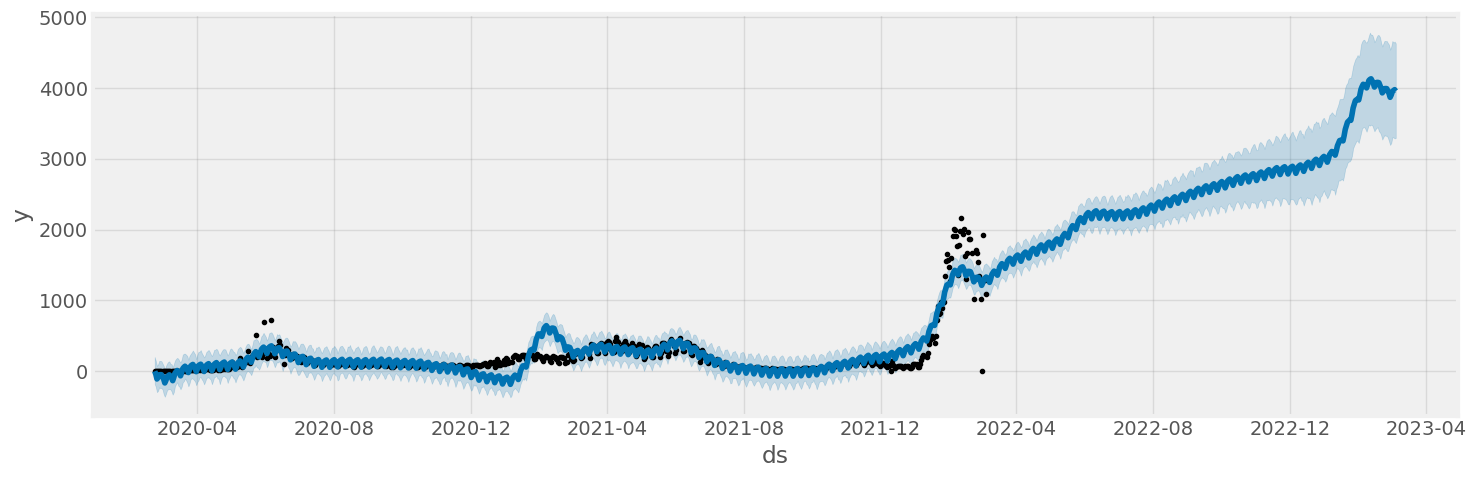

In [884]:
Cases_forecasting = ML_Model.plot(forecast, figsize=(15,5))

In [885]:
#Arima Model

In [886]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [887]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(date_train_asia,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7148.954, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7351.847, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7298.176, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7206.452, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7349.852, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7168.074, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7162.330, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6891.354, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7113.845, Time=0.65 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7053.574, Time=1.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6864.911, Time=3.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7104.225, Time=3.15 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6840.765, Time=3.47 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=6763.983, Time=5.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

In [888]:
arima_model_202 = ARIMA(date_train_asia, order=(3,1,3)).fit()

In [889]:
arima_model_202.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     new cases per million   No. Observations:                  679
Model:                    ARIMA(3, 1, 3)   Log Likelihood               -3423.756
Date:                   Wed, 05 Apr 2023   AIC                           6861.511
Time:                           07:15:44   BIC                           6893.145
Sample:                       02-23-2020   HQIC                          6873.758
                            - 01-01-2022                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9626      0.040     23.857      0.000       0.884       1.042
ar.L2         -0.6272      0.049    -12.700      0.000      -0.724      -0.530
ar.L3         -0.2953      0.039     -7.527      0.000      -0.372      -0.218
ma.L1         -1.7825      0.041    -43.349      0.000      -1.863      -1.702
ma.L2          1.5106      0.058     26.171      0.000       1.397       1.624
ma.L3         -0.4746      0.038    -12.369      0.000      -0.550      -0.399
sigma2      1422.5900     24.823     57.310      0.000    1373.939    1471.241
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):             41374.95
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             3.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [890]:
start = date_train_asia
end = date_test_asia
print(start,'to',end)

            new cases per million
Date                             
2020-02-23                  0.104
2020-02-24                  0.000
2020-02-25                  0.000
2020-02-26                  0.000
2020-02-27                  0.000
...                           ...
2021-12-28                 39.662
2021-12-29                 57.047
2021-12-30                 93.221
2021-12-31                 94.314
2022-01-01                 99.103

[679 rows x 1 columns] to             new cases per million
Date                             
2022-01-02                 99.103
2022-01-03                 51.790
2022-01-04                 54.704
2022-01-05                 95.772
2022-01-06                161.979
...                           ...
2022-03-01                  0.000
2022-03-02               1930.580
2022-03-03               1285.214
2022-03-04               1282.091
2022-03-05               1087.893

[63 rows x 1 columns]


In [891]:
#pred_future_10101=arima_model_202.predict(start=len(data2)+1,end=len(data2)+(360),dynamic=False)
pred_future_10101=arima_model_202.predict(start=len(date_test_asia)+1,end=len(date_test_asia)+(560),dynamic=False)
print("The length of pred_future values :",len(pred_future_10101))
pred_future_10101

The length of pred_future values : 560


2020-04-27     29.462053
2020-04-28     19.399890
2020-04-29     25.533979
2020-04-30     36.480930
2020-05-01     47.496306
                 ...    
2021-11-03     86.844670
2021-11-04     98.877597
2021-11-05    112.911508
2021-11-06    119.815953
2021-11-07    111.750227
Freq: D, Name: predicted_mean, Length: 560, dtype: float64

In [892]:
#pred_future_10101[['C,'forecast']].plot(figsize=(12,5),title="predicted graph",xlabel="Date",ylabel="confirmed")

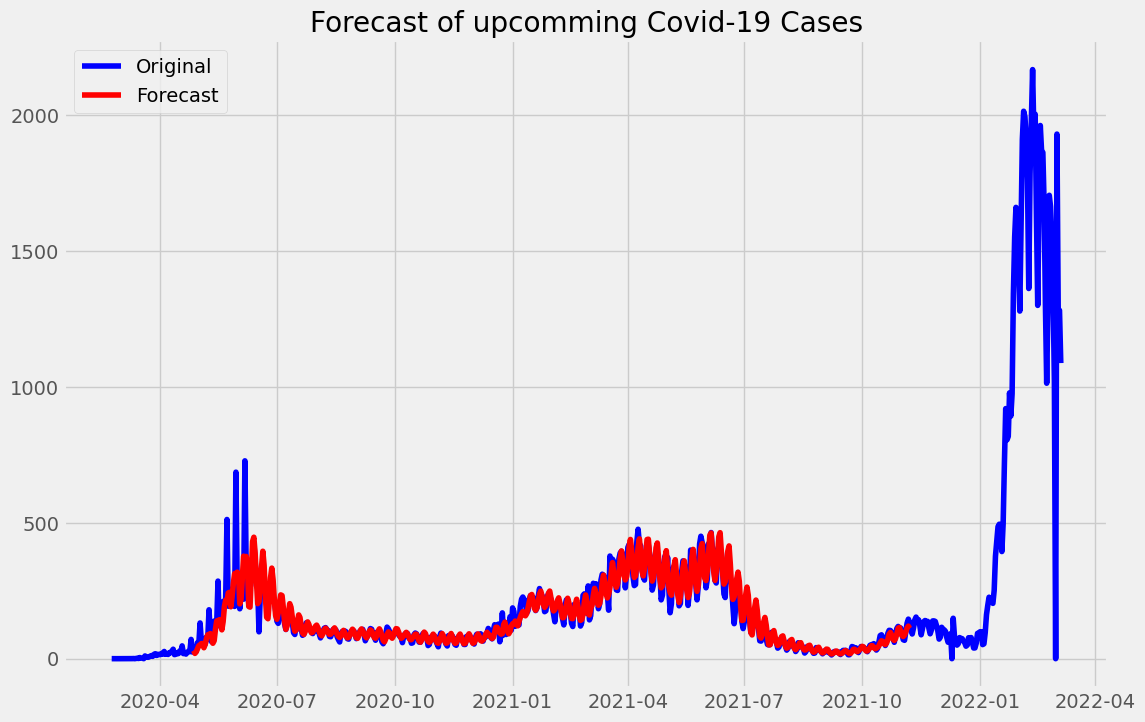

In [893]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(data2["new cases per million"], color='blue',label='Original')
fore = plt.plot(pred_future_10101, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()


In [894]:
# Define function to evaluate model performance
def evaluate_model(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mse, rmse, mape

In [895]:
# Define ARIMA model parameters
p = 2
d = 1
q = 2

In [896]:
# Fit the ARIMA model on train data
model = ARIMA(date_train_asia, order=(p, d, q))
results = model.fit()

In [897]:
n_days = 360

In [898]:
# Use the trained model to make predictions for the next n_days
forecast = results.forecast(steps=n_days)

In [899]:
# Create a date range for the forecasted dates
forecast_dates = pd.date_range(start=data2.index[-1], periods=n_days+1)[1:]

In [900]:
# Convert the forecasted values to a pandas DataFrame
forecast_df = pd.DataFrame({'Cases': forecast}, index=forecast_dates)

In [901]:
test_predictions = results.predict(start=date_test_asia.index[0], end=date_test_asia.index[-1], dynamic=False)


In [902]:
mse, rmse, mape = evaluate_model(test_predictions, date_test_asia)

In [903]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 1534761.16
Root Mean Squared Error (RMSE): 1238.85


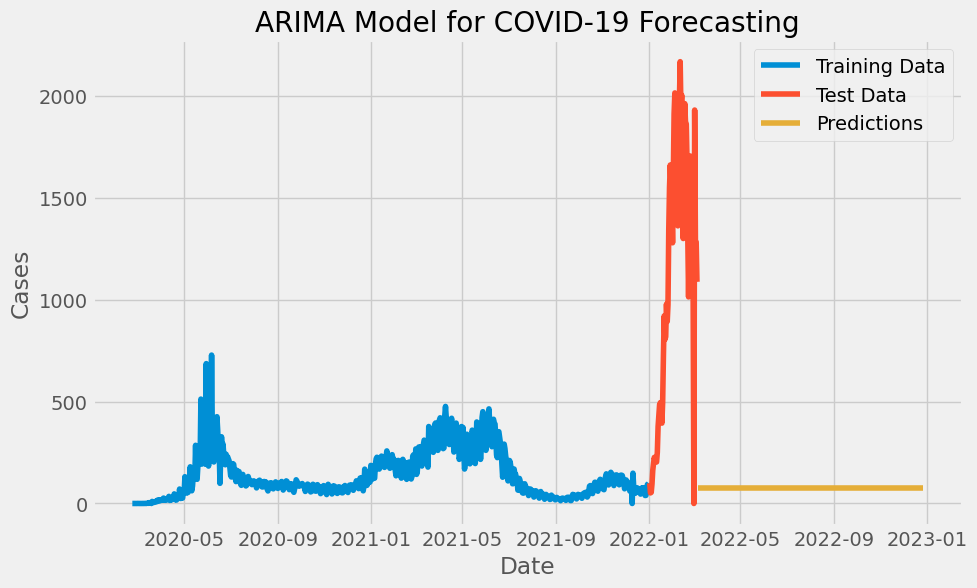

In [904]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(date_train_asia.index, date_train_asia.values, label='Training Data')
plt.plot(date_test_asia.index, date_test_asia.values, label='Test Data')
plt.plot(forecast_df.index, forecast_df.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [905]:
# Define function to evaluate model performance
def evaluate_model2(predictions2, actual2):
    mse2 = mean_squared_error(actual2, predictions2)
    rmse2 = np.sqrt(mse2)
    mape2 = np.mean(np.abs((actual2 - predictions2) / actual2)) * 100
    return mse2, rmse2, mape2

In [906]:
# Define ARIMA model parameters
p2 = 2
d2 = 1
q2 = 2

In [907]:
# Fit the ARIMA model on train data
model2 = ARIMA(date_train2, order=(p2, d2, q2))
results2 = model2.fit()

In [908]:
n_days2 = 360

In [909]:
# Use the trained model to make predictions for the next n_days
forecast2 = results.forecast(steps=n_days2)

In [910]:
forecast2

2022-01-02    76.235635
2022-01-03    80.512039
2022-01-04    73.765738
2022-01-05    78.811059
2022-01-06    74.413271
                ...    
2022-12-23    76.407594
2022-12-24    76.407594
2022-12-25    76.407594
2022-12-26    76.407594
2022-12-27    76.407594
Freq: D, Name: predicted_mean, Length: 360, dtype: float64

In [911]:
# Create a date range for the forecasted dates
forecast_dates2 = pd.date_range(start=data3.index[-1], periods=n_days2+1)[1:]

In [912]:
# Convert the forecasted values to a pandas DataFrame
forecast_df2 = pd.DataFrame({'Cases2': forecast2}, index=forecast_dates2)

In [913]:
test_predictions2 = results.predict(start=date_test2.index[0], end=date_test2.index[-1], dynamic=False)

In [914]:
mse2, rmse2, mape2 = evaluate_model2(test_predictions2, date_test2)

In [915]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse2:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 240921.12
Root Mean Squared Error (RMSE): 490.84


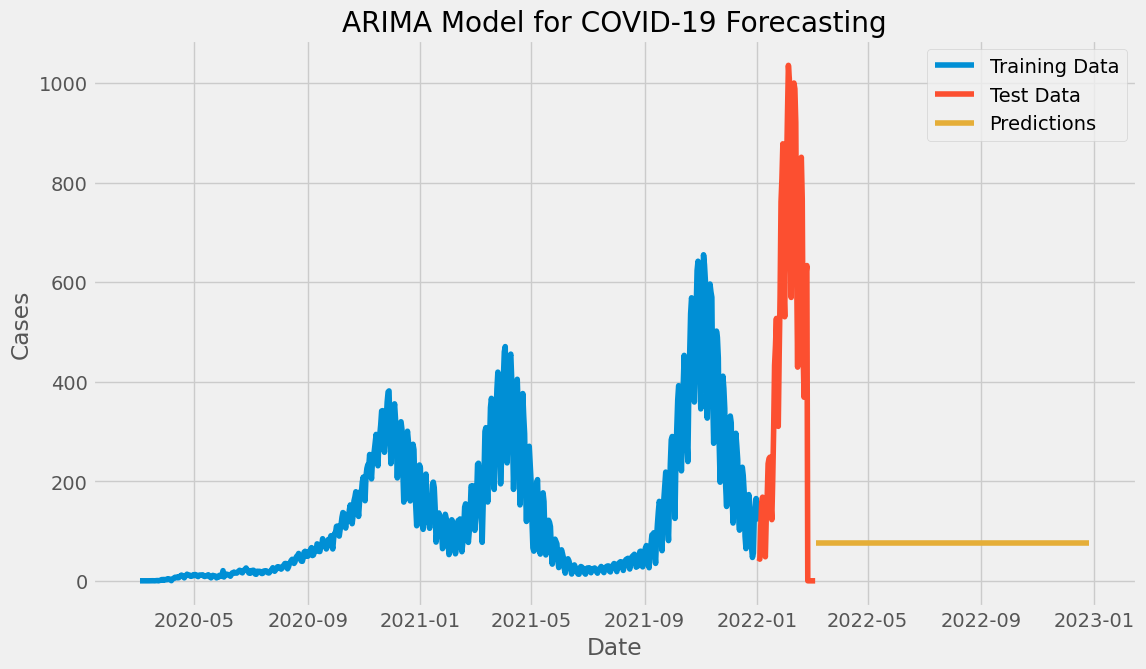

In [916]:
# Plot the actual and predicted values
plt.figure(figsize=(12, 7))
plt.plot(date_train2.index, date_train2.values, label='Training Data')
plt.plot(date_test2.index, date_test2.values, label='Test Data')
plt.plot(forecast_df2.index, forecast_df2.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [917]:
# Define function to evaluate model performance
def evaluate_model3(predictions3, actual3):
    mse3 = mean_squared_error(actual3, predictions3)
    rmse3 = np.sqrt(mse3)
    mape3 = np.mean(np.abs((actual3 - predictions3) / actual3)) * 100
    return mse3, rmse3, mape3

In [918]:
# Define ARIMA model parameters
p3 = 2
d3 = 1
q3 = 2

In [919]:
# Fit the ARIMA model on train data
model3 = ARIMA(date_train3, order=(p3, d3, q3))
results3 = model3.fit()

In [920]:
n_days3 = 360


In [921]:
# Use the trained model to make predictions for the next n_days
forecast3 = results.forecast(steps=n_days3)

In [922]:

# Create a date range for the forecasted dates
forecast_dates3 = pd.date_range(start=data4.index[-1], periods=n_days3+1)[1:]

In [923]:

# Convert the forecasted values to a pandas DataFrame
forecast_df3 = pd.DataFrame({'Cases': forecast3}, index=forecast_dates3)

In [924]:
test_predictions3 = results.predict(start=date_test3.index[0], end=date_test3.index[-1], dynamic=False)

In [925]:
mse3, rmse3, mape3 = evaluate_model3(test_predictions3, date_test3)

In [926]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse3:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse3:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 266093.30
Root Mean Squared Error (RMSE): 515.84


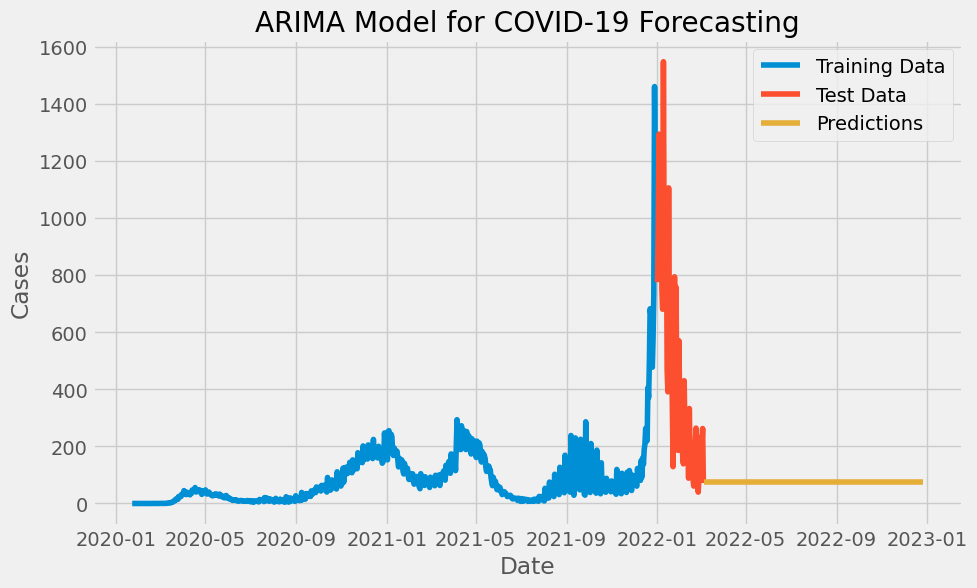

In [927]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(date_train3.index, date_train3.values, label='Training Data')
plt.plot(date_test3.index, date_test3.values, label='Test Data')
plt.plot(forecast_df3.index, forecast_df3.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [928]:
rmse_values2 = (rmse,rmse2,rmse3)

Text(0, 0.5, 'RMSE')

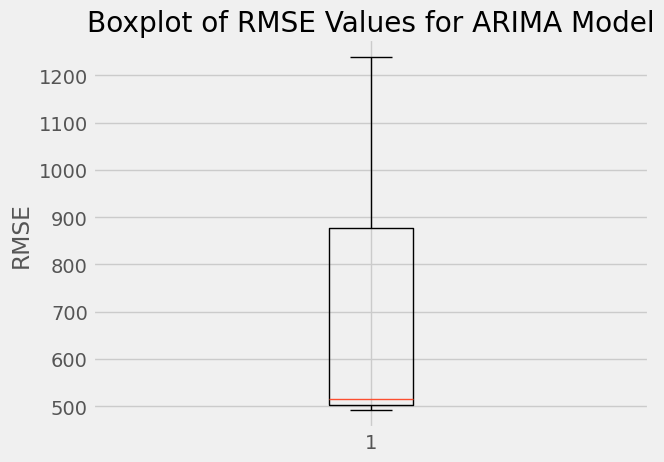

In [929]:
# Create a boxplot
fig, ax = plt.subplots()
ax.boxplot(rmse_values2)
ax.set_title('Boxplot of RMSE Values for ARIMA Model')
ax.set_ylabel('RMSE')


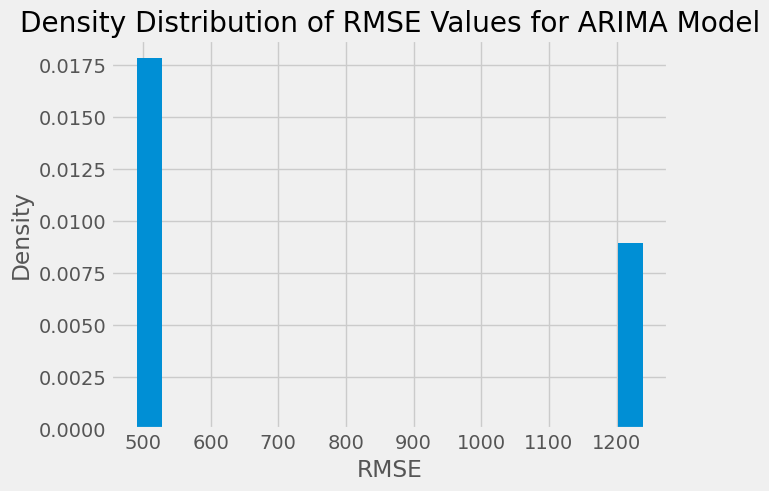

In [930]:
# Create a density distribution
fig, ax = plt.subplots()
ax.hist(rmse_values2, density=True, bins=20)
ax.set_title('Density Distribution of RMSE Values for ARIMA Model')
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
plt.show()